# Setup

In [18]:
import torch
import transformer_lens as tl
from typing import Callable
from einops import rearrange, einsum

from circuit_finder.core.types import LayerIndex
from circuit_finder.pretrained import (
    load_attn_saes,
    load_mlp_transcoders,
)

from circuit_finder.core.types import (
    LayerIndex,
    FeatureIndex,
    TokenIndex,
    Node,
    Edge,
    Attrib,
    ModuleName,
    parse_node_name,
)


# Load Models

In [19]:
# Load models
model = tl.HookedTransformer.from_pretrained(
    "gpt2",
    device="cuda",
    fold_ln=True,
    center_writing_weights=True,
    center_unembed=True,
)

/workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [20]:
# flake8: noqa
# %%
"""Demonstrate how to do linear edge attribution patching using LEAP"""


def preprocess_attn_saes(
    attn_saes_in: dict[LayerIndex, tl.HookedSAE],
    model: tl.HookedTransformer,
) -> dict[LayerIndex, tl.HookedSAE]:
    """Preprocess the SAEs to have the same feature dimension."""
    # NOTE: currently do this by chopping off features, but this loses information
    # A simple fix is to extend all SAEs to have the same feature dimension by adding zeros
    # TODO: implement fix
    attn_saes = {}
    for layer, sae in attn_saes_in.items():
        # chop off features so all have same size TODO fix this
        sae.W_enc = torch.nn.Parameter(sae.W_enc[:, :24576], requires_grad=False)
        sae.b_enc = torch.nn.Parameter(sae.b_enc[:24576], requires_grad=False)
        sae.W_dec = torch.nn.Parameter(sae.W_dec[:24576, :], requires_grad=False)
        sae.b_dec = torch.nn.Parameter(sae.b_dec, requires_grad=False)

        # normalize so decoder ols have norm=1 when viewed as resid vectors
        W_dec_z = rearrange(
            sae.W_dec, "nf (nhead dhead) -> nf nhead dhead", nhead=model.cfg.n_heads
        )
        W_dec_resid = einsum(
            W_dec_z, model.W_O[layer], "nf nhead dhead, nhead dhead dmodel -> nf dmodel"
        )
        norms = W_dec_resid.norm(dim=-1, keepdim=True)  # [nf, 1]

        normed_sae = sae
        normed_sae.W_dec = torch.nn.Parameter(sae.W_dec / norms)
        normed_sae.W_enc = torch.nn.Parameter(sae.W_enc * norms.T)
        normed_sae.b_enc = torch.nn.Parameter(sae.b_enc * norms.squeeze())

        attn_saes[layer] = normed_sae

    return attn_saes


attn_saes = load_attn_saes()
attn_saes = preprocess_attn_saes(attn_saes, model)  # type: ignore
transcoders = load_mlp_transcoders()

print(len(attn_saes))
print(len(transcoders))
print(transcoders.keys())
print(attn_saes.keys())

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

12
12
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


# Define Dataset, Metric

In [11]:
from circuit_finder.data.ioi import get_ioi_data
from eindex import eindex
from rich import print as rprint
from rich.table import Table
from circuit_finder.utils import get_answer_tokens

clean_prompts, corrupt_prompts, answers = get_ioi_data()

clean_prompt_tokens = model.to_tokens(clean_prompts) # type: ignore
corrupt_prompt_tokens = model.to_tokens(corrupt_prompts) # type: ignore
answer_tokens = get_answer_tokens(answers, model)  # type: ignore
# Print the data
table = Table("Prompt", "Correct", "Incorrect", title="Prompts & Answers:")
for prompt, answer in zip(clean_prompts, answers):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]))
rprint(table)

                                 Prompts & Answers:                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓
┃ Prompt                                                     ┃ Correct ┃ Incorrect ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩
│ When John and Mary went to the shops, Mary gave the bag to │ ' John' │ ' Mary'   │
│ When John and Mary went to the shops, John gave the bag to │ ' Mary' │ ' John'   │
└────────────────────────────────────────────────────────────┴─────────┴───────────┘

In [16]:
from jaxtyping import Float
from torch import Tensor
from circuit_finder.utils import logits_to_ave_logit_diff


# Define average difference metric
def metric_fn(model, prompt_tokens, answer_tokens) -> Float[Tensor, " batch"]:
    logits, _ = model.run_with_cache(prompt_tokens)
    mean_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens, per_prompt = True)
    return mean_logit_diff


print("Clean metric:", metric_fn(model, clean_prompt_tokens, answer_tokens))
print("Corrupt metric:", metric_fn(model, corrupt_prompt_tokens, answer_tokens))

Clean metric: tensor([3.2016, 3.3367], device='cuda:0', grad_fn=<SubBackward0>)
Corrupt metric: tensor([ 0.3331, -0.3331], device='cuda:0', grad_fn=<SubBackward0>)


# Define LEAP

In [21]:
# type: ignore
"""Linear Edge Attribution Patching.

Similar to Edge Attribution Patching, calculates the effect of edges on some downstream metric.
However, takes advantage of linearity afforded by transcoders and MLPs to parallelize
"""

# %%
import gc
import torch
import transformer_lens as tl

from transcoders_slim.transcoder import Transcoder
from torch import Tensor
from jaxtyping import Int, Float
from dataclasses import dataclass
from einops import rearrange, einsum
from typing import Literal, TypeGuard


def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

# %%
@dataclass
class LEAPConfig:
    threshold: float = 0.01
    contrast_pairs: bool = False


class LEAP:
    """
    Linear Edge Attribution Patching

    Similar to edge attribution patching, but fully linearises the network to compute attributions exactly
    """

    # Models
    model: tl.HookedTransformer
    attn_saes: dict[LayerIndex, tl.HookedSAE]
    transcoders: dict[LayerIndex, Transcoder]

    # Data
    tokens: Int[Tensor, "batch seq"]
    corrupt_tokens: Int[Tensor, "batch seq"]

    # Intermediate computations
    mlp_feature_acts: Float[Tensor, "seq layer d_trans"]
    mlp_is_active: Float[Tensor, "seq layer d_trans"]
    attn_feature_acts: Float[Tensor, "seq layer d_sae"]
    attn_is_active: Float[Tensor, "seq layer d_sae"]
    mlp_errors: Float[Tensor, "seq layer d_model"]
    attn_errors: Float[Tensor, "seq layer d_model"]

    # Graph
    graph: list[tuple[Edge, Attrib]]

    def __init__(
        self,
        cfg: LEAPConfig,
        tokens: Int[torch.Tensor, "batch seq"],
        model: tl.HookedTransformer,
        attn_saes: dict[LayerIndex, tl.HookedSAE],  # layer index: attn-out SAE
        transcoders: dict[LayerIndex, Transcoder],  # layer index: mlp transcoder
        metric: Callable[[tl.HookedTransformer, Tokens], Tensor],
        corrupt_tokens: Int[
            torch.Tensor, "batch seq"
        ] = None,  # only specify if contrast_pairs = True
    ):
        self.cfg = cfg
        self.tokens = tokens
        self.model = model
        self.attn_saes = attn_saes
        self.transcoders = transcoders
        self.metric = metric
        self.corrupt_tokens = corrupt_tokens

        if self.cfg.contrast_pairs:
            assert self.tokens.shape == self.corrupt_tokens.shape

        # Store some params for convenience
        self.d_trans = transcoders[0].W_enc.size(1)
        self.d_sae = attn_saes[0].W_enc.size(1)
        self.batch, self.n_seq = tokens.size()
        self.d_model = model.cfg.d_model
        self.n_layers = model.cfg.n_layers
        self.layers = range(model.cfg.n_layers)

        # Cache feature acts, pattern, layernorm scales, SAE errors, active feature IDs
        self.get_initial_cache()

        # Kissane et al's attention SAEs are trained at hook_z, concatenated across head_idx dimension.
        # Here we process the decoder matrices so their columns can be viewed as residual vectors.
        attn_all_W_dec_z_cat = torch.stack(
            [attn_saes[i].W_dec for i in self.layers]
        )  # [layer d_sae d_model]
        attn_all_W_dec_z = rearrange(
            attn_all_W_dec_z_cat,
            "layer d_sae (n_heads d_head) -> layer d_sae n_heads d_head",
            n_heads=model.cfg.n_heads,
        )
        self.attn_all_W_dec_resid = einsum(
            attn_all_W_dec_z,
            model.W_O,
            "layer d_sae n_heads d_head , layer n_heads d_head d_model -> layer d_sae d_model",
        )

        # NOTE: We'll store (edge, attrib) pairs here.
        # Initialise by making the metric an important node, by hand.
        # edge = (downstream_node, upstream_node)
        # node = "{module_name}.{layer}.{pos}.{feature_id}"
        self.graph: list[tuple[Edge, Attrib]] = [
            (("null", f"metric.{self.n_layers}.{self.n_seq-2}.0"), 0)
        ]

        self.error_graph = []

    def get_important_edges(self) -> list[Edge]:
        return [edge for edge, _ in self.graph]

    def get_initial_cache(self):
        """Run model on tokens. Grab acts at mlp_in, and run them through
        transcoders to get all transcoder feature acts. Grab acts at hook_z,
        concatenate on head_idx dim, and run through attn_sae to get all
        attention SAE feature acts"""
        # This code is verbose but totally trivial!

        # Run model and cache the acts we need
        names_filter: HookNameFilterFn = lambda x: (
            x.endswith("ln2.hook_normalized")
            or x.endswith("mlp_out")
            or x.endswith("hook_z")
            or x.endswith("pattern")
            or x.endswith("hook_scale")
        )
        _, cache = self.model.run_with_cache(
            self.tokens, return_type="loss", names_filter=names_filter
        )

        if self.cfg.contrast_pairs:
            names_filter = lambda x: (
                x.endswith("ln2.hook_normalized")
                or x.endswith("mlp_out")
                or x.endswith("hook_z")
            )
            _, corrupt_cache = self.model.run_with_cache(
                self.corrupt_tokens, return_type="loss", names_filter=names_filter
            )

        # Save attention patterns (avg over batch and head) and layernorm scales (avg over batch)
        self.pattern: Float[Tensor, "layer head q_pos k_pos"] = torch.stack(
            [cache["pattern", layer].mean(0) for layer in self.layers]
        )
        self.attn_layernorm_scales: Float[Tensor, "layer pos"] = torch.stack(
            [
                cache[f"blocks.{layer}.ln1.hook_scale"].mean(dim=0)
                for layer in self.layers
            ]
        )  # [layer pos]
        self.mlp_layernorm_scales: Float[Tensor, "layer pos"] = torch.stack(
            [
                cache[f"blocks.{layer}.ln2.hook_scale"].mean(dim=0)
                for layer in self.layers
            ]
        )  # [layer pos]

        # Save feature acts
        # Initialise empty tensors to store feature acts and is_active (both batchmeaned)
        self.mlp_feature_acts: Float[Tensor, "seq layer d_trans"] = torch.empty(
            self.n_seq, self.n_layers, self.d_trans, device=device
        )
        self.mlp_is_active: Float[Tensor, "seq layer d_trans"] = torch.empty(
            self.n_seq, self.n_layers, self.d_trans, device=device
        )
        self.attn_feature_acts: Float[Tensor, "seq layer d_sae"] = torch.empty(
            self.n_seq, self.n_layers, self.d_sae, device=device
        )
        self.attn_is_active: Float[Tensor, "seq layer d_sae"] = torch.empty(
            self.n_seq, self.n_layers, self.d_sae, device=device
        )
        self.mlp_errors: Float[Tensor, "seq layer d_model"] = torch.empty(
            self.n_seq, self.n_layers, self.d_model, device=device
        )
        self.attn_errors: Float[Tensor, "seq layer d_model"] = torch.empty(
            self.n_seq, self.n_layers, self.d_model, device=device
        )

        # Add feature acts to the empty tensors, layer by layer
        for layer in range(self.n_layers):
            mlp_in_pt = f"blocks.{layer}.ln2.hook_normalized"
            mlp_out_pt = f"blocks.{layer}.hook_mlp_out"
            attn_out_pt = f"blocks.{layer}.attn.hook_z"

            # Get MLP feature acts and recons errors
            mlp_recons, mlp_feature_acts = self.transcoders[layer](cache[mlp_in_pt])[:2]
            if self.cfg.contrast_pairs:  # in contrast pairs case, feature_acts now really refers to the change in feature acts
                mlp_feature_acts -= self.transcoders[layer](corrupt_cache[mlp_in_pt])[1]
            self.mlp_feature_acts[:, layer, :] = mlp_feature_acts.mean(0)
            self.mlp_is_active[:, layer, :] = (mlp_feature_acts > 0).float().mean(0)
            self.mlp_errors[:, layer, :] = (cache[mlp_out_pt] - mlp_recons).mean(0)

            # Get attention feature acts and recons errors (remember to be careful with z concatenation!)
            z_concat = rearrange(
                cache[attn_out_pt],
                "batch seq n_heads d_head -> batch seq (n_heads d_head)",
            )
            attn_recons, sae_cache = self.attn_saes[layer].run_with_cache(
                z_concat, names_filter="hook_sae_acts_post"
            )
            attn_feature_acts = sae_cache["hook_sae_acts_post"]

            if self.cfg.contrast_pairs:
                z_concat = rearrange(
                    corrupt_cache[attn_out_pt],
                    "batch seq n_heads d_head -> batch seq (n_heads d_head)",
                )
                attn_recons, sae_cache = self.attn_saes[layer].run_with_cache(
                    z_concat, names_filter="hook_sae_acts_post"
                )
                attn_feature_acts -= sae_cache["hook_sae_acts_post"]

            self.attn_feature_acts[:, layer, :] = attn_feature_acts.mean(0)
            self.attn_is_active[:, layer, :] = (attn_feature_acts > 0).float().mean(0)
            z_error = rearrange(
                (attn_recons - z_concat).mean(0),
                "seq (n_heads d_head) -> seq n_heads d_head",
                n_heads=self.model.cfg.n_heads,
            )
            resid_error = einsum(
                z_error,
                self.model.W_O[layer],
                "seq n_heads d_heads, n_heads d_head d_model -> seq d_model",
            )
            self.attn_errors[:, layer, :] = resid_error

        # Get ids of active features
        self.mlp_active_feature_ids = torch.where(self.mlp_is_active.sum(0) > 0)
        self.attn_active_feature_ids = torch.where(self.attn_is_active.sum(0) > 0)

    def metric_step(self):
        """Step 0 of circuit discovery: get attributions from each node to the metric.

        TODO currently, if metric depends on multiple token positions, this will
        sum the gradient over those positions. Do we want to be more general, i.e.
        store separate gradients at each position? Or maybe we don't care..."""
        imp_down_feature_ids, imp_down_pos = self.get_imp_feature_ids_and_pos(
            "metric", self.n_layers
        )

        self.model.blocks[self.model.cfg.n_layers - 1].mlp.b_out.grad = None
        m_B: Float[Tensor, " batch"] = self.metric(self.model, self.tokens)
        m = m_B.mean()
        m.backward()  # TODO don't actually need backward through whole model. If m is linear, we can disable autograd!

        # Sneaky way to get d(metric)/d(resid_post_final)
        grad = self.model.blocks[self.model.cfg.n_layers - 1].mlp.b_out.grad.unsqueeze(
            0
        )
        self.compute_and_save_attribs(
            grad, "metric", self.n_layers, imp_down_feature_ids, imp_down_pos
        )

    def mlp_step(self, down_layer):
        """For each imp node at this MLP, compute attrib wrt all previous nodes"""

        # Get the imp features coming out of the MLP, and the positions at which they're imp
        imp_down_feature_ids, imp_down_pos = self.get_imp_feature_ids_and_pos(
            "mlp", down_layer
        )
        # For each imp downstream (feature_id, pos) pair, get batchmeaned is_active, and the corresponding encoder row
        imp_active = self.mlp_is_active[
            imp_down_pos, down_layer, imp_down_feature_ids
        ]  # [imp_id]
        imp_enc_cols = self.transcoders[down_layer].W_enc[
            :, imp_down_feature_ids
        ]  # [d_model, imp_id]
        imp_layernorm_scales = self.mlp_layernorm_scales[
            down_layer, imp_down_pos
        ]  # [imp_id, 1]

        # The grad of these imp feature acts is just the corresponding row of W_enc (scaled by layernorm)
        grad = einsum(
            imp_active, imp_enc_cols, "imp_id, d_model imp_id -> imp_id d_model"
        )
        grad /= imp_layernorm_scales

        self.compute_and_save_attribs(
            grad, "mlp", down_layer, imp_down_feature_ids, imp_down_pos
        )

    def ov_step(self, down_layer):
        """For each imp node at this attention layer, compute attrib wrt all previous nodes *via the OV circuit*"""

        # Get the imp features coming out of the attention layer, and the positions at which they're imp
        imp_down_feature_ids, imp_down_pos = self.get_imp_feature_ids_and_pos(
            "attn", down_layer
        )

        # For each imp downstream (feature_id, pos) pair, get batchmeaned is_active, encoder row, and pattern
        imp_active = self.attn_is_active[
            imp_down_pos, down_layer, imp_down_feature_ids
        ]  # [imp_id]
        imp_enc_rows = self.attn_saes[down_layer].W_enc[
            :, imp_down_feature_ids
        ]  # [d_model, imp_id]
        imp_enc_rows_z = rearrange(
            imp_enc_rows,
            "(head_id d_head) imp_id -> head_id d_head imp_id",
            head_id=self.model.cfg.n_heads,
        )
        imp_patterns = self.pattern[
            down_layer, :, imp_down_pos, :
        ]  # [head imp_id, kpos]
        imp_layernorm_scales = self.attn_layernorm_scales[down_layer].unsqueeze(
            1
        )  # [kpos, 1, 1]

        grad = einsum(
            imp_active,
            imp_enc_rows_z,
            self.model.W_V[down_layer],
            imp_patterns,
            "imp_id, head_id d_head imp_id, head_id d_model d_head, head_id imp_id kpos -> kpos imp_id d_model",
        )
        grad /= imp_layernorm_scales

        self.compute_and_save_attribs(
            grad, "attn", down_layer, imp_down_feature_ids, imp_down_pos
        )

    """ Helper functions """

    # TODO: This should be made an attribute of the graph instead
    def get_imp_feature_ids_and_pos(
        self, down_module: ModuleName, down_layer: LayerIndex
    ) -> tuple[list[FeatureIndex], list[TokenIndex]]:
        """Get the feature indices and token positiosn of important nodes at a given layer

        Returns:
            imp_feature_ids : list of feature indices of important nodes.
            imp_pos : list of token positions of important nodes.

        These can be zipped together to get the (feature_id, pos) pairs of important nodes.

        module : name of upstream module."""
        imp_feature_ids: list[FeatureIndex] = []
        imp_pos: list[TokenIndex] = []

        # Get all nodes that are currently in the graph
        up_nodes_set: set[Node] = set()
        for edge in self.get_important_edges():
            _, upstream = edge
            up_nodes_set.add(upstream)
        up_nodes_deduped: list[Node] = list(up_nodes_set)

        # Filter by module and layer
        # TODO: It seems like we could do this previously but ig it doesn't matter.
        for up_node in up_nodes_deduped:
            down_module_, down_layer_, pos, feature_id = parse_node_name(up_node)
            if down_module_ == down_module and down_layer_ == down_layer:
                imp_feature_ids += [int(feature_id)]
                imp_pos += [int(pos)]
        return imp_feature_ids, imp_pos

    def get_active_mlp_W_dec(
        self, down_layer: LayerIndex
    ) -> tuple[Tensor, Tensor, Tensor]:
        """so we don't have to dot with *every* upstream feature"""
        mlp_up_active_layers = self.mlp_active_feature_ids[0][
            self.mlp_active_feature_ids[0] < down_layer
        ]
        mlp_up_active_feature_ids = self.mlp_active_feature_ids[1][
            self.mlp_active_feature_ids[0] < down_layer
        ]
        mlp_active_W_dec = torch.stack(
            [self.transcoders[i].W_dec for i in range(down_layer)]
        )[mlp_up_active_layers, mlp_up_active_feature_ids, :]
        return mlp_active_W_dec, mlp_up_active_layers, mlp_up_active_feature_ids

    def get_active_attn_W_dec(
        self, down_layer: LayerIndex, down_module: ModuleName
    ) -> tuple[Tensor, Tensor, Tensor]:
        """so we don't have to dot with *every* upstream feature"""
        max_layer = down_layer
        if down_module == "mlp":  # mlp sees attn from same layer!
            max_layer += 1
        attn_up_active_layers = self.attn_active_feature_ids[0][
            self.attn_active_feature_ids[0] < max_layer
        ]
        attn_up_active_feature_ids = self.attn_active_feature_ids[1][
            self.attn_active_feature_ids[0] < max_layer
        ]
        attn_active_W_dec = self.attn_all_W_dec_resid[
            attn_up_active_layers, attn_up_active_feature_ids, :
        ]
        return attn_active_W_dec, attn_up_active_layers, attn_up_active_feature_ids

    def compute_and_save_attribs(
        self, grad, down_module, down_layer, imp_down_feature_ids, imp_down_pos
    ):
        """grad : [... imp_id, d_model]"""

        # ----- UPSTREAM MLP ATTRIBS ------
        # Get upstream feature acts, since we'll need this for attrib computation
        mlp_active_W_dec, mlp_up_active_layers, mlp_up_active_feature_ids = (
            self.get_active_mlp_W_dec(down_layer)
        )
        active_mlp_feature_acts = self.mlp_feature_acts[
            :, mlp_up_active_layers, mlp_up_active_feature_ids
        ]  # [pos, up_active_id]

        if down_module in ["mlp", "metric"]:  # down mlp doesn't mix positions
            active_mlp_feature_acts: Float[Tensor, "imp_id, up_active_id"] = (
                active_mlp_feature_acts[imp_down_pos]
            )

            imp_mlp_errors: Float[Tensor, "imp_id, layer, d_model"] = self.mlp_errors[
                imp_down_pos
            ]

            # Compute attribs of imp nodes wrt all upstream MLP nodes
            mlp_attribs = einsum(
                active_mlp_feature_acts,
                mlp_active_W_dec,
                grad,
                "imp_id up_active_id, up_active_id d_model, imp_id d_model -> imp_id up_active_id",
            )

            mlp_error_attribs = einsum(
                imp_mlp_errors[:, :down_layer],
                grad,
                "imp_id layer d_model, imp_id d_model -> imp_id layer",
            )

        elif down_module in ["attn"]:
            # Compute attribs of imp nodes wrt all upstream MLP nodes
            mlp_attribs = einsum(
                active_mlp_feature_acts,
                mlp_active_W_dec,
                grad,
                "seq up_active_id, up_active_id d_model, seq imp_id d_model -> seq imp_id up_active_id",
            )

            mlp_error_attribs = einsum(
                self.mlp_errors[:, :down_layer],
                grad,
                "seq layer d_model, seq imp_id d_model -> seq imp_id layer",
            )
        else:
            print(down_module)
            raise ValueError("down_module must be one of ['mlp', 'attn', 'metric']")

        # attrib can be at most the value of the original downstream feature act
        # mlp_attribs = torch.min(mlp_attribs, imp_mlp_feature_acts)
        self.add_to_graph(
            mlp_attribs,
            mlp_error_attribs,
            imp_down_feature_ids,
            imp_down_pos,
            down_module_name=down_module,
            down_layer=down_layer,
            up_module_name="mlp",
            up_active_layers=mlp_up_active_layers,
            up_active_feature_ids=mlp_up_active_feature_ids,
        )

        del mlp_attribs
        clear_mem()

        # ----- UPSTREAM ATTENTION ATTRIBS (do exactly the same for attention) -----
        attn_active_W_dec, attn_up_active_layers, attn_up_active_feature_ids = (
            self.get_active_attn_W_dec(down_layer, down_module)
        )
        active_attn_feature_acts: Float[Tensor, "imp_id, up_active_id"] = (
            self.attn_feature_acts[:, attn_up_active_layers, attn_up_active_feature_ids]
        )

        if down_module in ["mlp", "metric"]:  # down mlp doesn't mix positions
            active_attn_feature_acts = active_attn_feature_acts[
                imp_down_pos
            ]  # [imp_id, up_active_id]
            imp_attn_errors: Float[Tensor, "imp_id, layer, d_model"] = self.attn_errors[
                imp_down_pos
            ]
            attn_attribs = einsum(
                active_attn_feature_acts,
                attn_active_W_dec,
                grad,
                "imp_id up_active_id, up_active_id d_model, imp_id d_model -> imp_id up_active_id",
            )

            attn_error_attribs = einsum(
                imp_attn_errors[
                    :, : down_layer + 1
                ],  # MLP sees attention from same layer
                grad,
                "imp_id layer d_model, imp_id d_model -> imp_id layer",
            )

        elif down_module in ["attn"]:
            attn_attribs = einsum(
                active_attn_feature_acts,
                attn_active_W_dec,
                grad,
                "seq up_active_id, up_active_id d_model, seq imp_id d_model -> seq imp_id up_active_id",
            )

            attn_error_attribs = einsum(
                self.attn_errors[:, :down_layer],
                grad,
                "seq layer d_model, seq imp_id d_model -> seq imp_id layer",
            )
        else:
            raise ValueError("down_module must be one of ['mlp', 'attn', 'metric']")

        self.add_to_graph(
            attn_attribs,
            attn_error_attribs,
            imp_down_feature_ids,
            imp_down_pos,
            down_module_name=down_module,
            down_layer=down_layer,
            up_module_name="attn",
            up_active_layers=attn_up_active_layers,
            up_active_feature_ids=attn_up_active_feature_ids,
        )

        del attn_attribs
        clear_mem()

    def add_to_graph(
        self,
        attribs,  # [seq, imp_id, up_active_id] if down_module==attn.  otherwise [imp_id, up_active_id]
        error_attribs,  # [seq, imp_id, layer] if down_module==attn.  otherwise [imp_id, layer]
        imp_down_feature_ids,
        imp_down_pos,
        down_module_name: ModuleName,
        down_layer: LayerIndex,
        up_module_name: ModuleName,
        up_active_layers,
        up_active_feature_ids,
    ):
        if len(imp_down_pos) == 0:
            return
        # Convert lists to PyTorch tensors
        imp_down_feature_ids = torch.tensor(
            imp_down_feature_ids, dtype=torch.long, device=attribs.device
        )
        imp_down_pos = torch.tensor(
            imp_down_pos, dtype=torch.long, device=attribs.device
        )

        # Create a mask where attribs are greater than the threshold
        mask = attribs > self.cfg.threshold
        # Use the mask to find the relevant indices
        if down_module_name in ["mlp", "metric"]:
            imp_ids, up_active_ids = torch.where(mask)
            attrib_values = attribs[imp_ids, up_active_ids].flatten()

        elif down_module_name == "attn":
            up_seqs, imp_ids, up_active_ids = torch.where(mask)
            attrib_values = attribs[up_seqs, imp_ids, up_active_ids].flatten()
        else:
            raise ValueError(
                "down_module_name must be one of ['mlp', 'attn', 'metric']"
            )

        # Get corresponding down_feature_ids and seqs using tensor indexing
        down_feature_ids = imp_down_feature_ids[imp_ids]
        down_seqs = imp_down_pos[imp_ids]

        # metric and mlp don't mix positions
        if down_module_name in ["mlp", "metric"]:
            up_seqs = down_seqs

        up_feature_ids = up_active_feature_ids[up_active_ids]
        up_layer_ids = up_active_layers[up_active_ids]

        # Construct edges based on the indices and mask
        edges = [
            (
                f"{down_module_name}.{down_layer}.{down_seqs[i]}.{down_feature_ids[i]}",
                f"{up_module_name}.{up_layer_ids[i]}.{up_seqs[i]}.{up_feature_ids[i]}",
            )
            for i in range(attrib_values.size(0))
        ]

        # Append to the graph
        for edge, value in zip(edges, attrib_values):
            # don't bother adding nodes at pos=0, since this is BOS token
            if not edge[1].split(".")[2] == "0":
                self.graph.append((edge, value.item()))  # type: ignore

        print("down seqs", down_seqs.shape)
        print("up seqs", up_seqs.shape)
        print("imp down pos: ", imp_down_pos.shape)
        print("error attribs: ", error_attribs.shape)
        # Add errors
        if down_module_name in ["mlp", "metric"]:
            # error_attribs : [imp_id, layer]
            for imp_id in range(error_attribs.size(0)):
                for up_layer in range(error_attribs.size(1)):
                    edge = (
                        f"{down_module_name}.{down_layer}.{imp_down_pos[imp_id]}.{imp_down_feature_ids[imp_id]}",
                        f"{up_module_name}_error.{up_layer}.{imp_down_pos[imp_id]}.{0}",
                    )
                    attrib = error_attribs[imp_id, up_layer]
                    self.error_graph.append((edge, attrib.item()))

        if down_module_name in ["attn"]:
            # error_attribs : [seq, imp_id, layer]
            for imp_id in range(error_attribs.size(1)):
                for up_layer in range(error_attribs.size(2)):
                    for up_seq in range(error_attribs.size(0)):
                        edge = (
                            f"{down_module_name}.{down_layer}.{imp_down_pos[imp_id]}.{imp_down_feature_ids[imp_id]}",
                            f"{up_module_name}_error.{up_layer}.{up_seq}.{0}",
                        )
                        attrib = error_attribs[up_seq, imp_id, up_layer]
                        self.error_graph.append((edge, attrib.item()))

# Run LEAP

In [26]:
from functools import partial

# Set up LEAP
cfg = LEAPConfig(threshold=0.03, contrast_pairs=True)
leap = LEAP(
    cfg,
    clean_prompt_tokens,
    model,
    attn_saes, # type: ignore
    transcoders,
    metric=partial(metric_fn, answer_tokens = answer_tokens),
    corrupt_tokens=corrupt_prompt_tokens,
)

# Run LEAP
leap.metric_step()
print("num edges = ", len(leap.graph))

for layer in reversed(range(1, model.cfg.n_layers)):
    print("layer : ", layer)
    leap.mlp_step(layer)
    print("num edges = ", len(leap.graph))
    leap.ov_step(layer)
    print("num edges = ", len(leap.graph))
    print()

# Inspect graph found via LEAP
attn_attn = [
    (edge, attrib)
    for (edge, attrib) in leap.graph[1:]
    if edge[0].startswith("attn") and edge[1].startswith("attn")
]
attn_mlp = [
    (edge, attrib)
    for (edge, attrib) in leap.graph[1:]
    if edge[0].startswith("attn") and edge[1].startswith("mlp")
]
mlp_attn = [
    (edge, attrib)
    for (edge, attrib) in leap.graph[1:]
    if edge[0].startswith("mlp") and edge[1].startswith("attn")
]
mlp_mlp = [
    (edge, attrib)
    for (edge, attrib) in leap.graph[1:]
    if edge[0].startswith("mlp") and edge[1].startswith("mlp")
]

print(len(attn_attn), len(attn_mlp), len(mlp_attn), len(mlp_mlp))
# %%
# Print edges found via LEAP
print(len(leap.graph))
for edge in leap.graph:
    print(edge)

# %%
from circuit_finder.patching.eap_graph import EAPGraph

import pickle

graph = leap.graph
graph = EAPGraph(graph)
pickle.dump(graph, open("graph.pkl", "wb"))

down seqs torch.Size([0])
up seqs torch.Size([0])
imp down pos:  torch.Size([1])
error attribs:  torch.Size([1, 12])
down seqs torch.Size([1])
up seqs torch.Size([1])
imp down pos:  torch.Size([1])
error attribs:  torch.Size([1, 12])
num edges =  2
layer :  11
num edges =  2
down seqs torch.Size([65])
up seqs torch.Size([65])
imp down pos:  torch.Size([1])
error attribs:  torch.Size([15, 1, 11])
down seqs torch.Size([12])
up seqs torch.Size([12])
imp down pos:  torch.Size([1])
error attribs:  torch.Size([15, 1, 11])
num edges =  79

layer :  10
down seqs torch.Size([350])
up seqs torch.Size([350])
imp down pos:  torch.Size([15])
error attribs:  torch.Size([15, 10])
down seqs torch.Size([229])
up seqs torch.Size([229])
imp down pos:  torch.Size([15])
error attribs:  torch.Size([15, 11])
num edges =  658
down seqs torch.Size([252])
up seqs torch.Size([252])
imp down pos:  torch.Size([15])
error attribs:  torch.Size([15, 15, 10])
down seqs torch.Size([74])
up seqs torch.Size([74])
imp dow

# Inspect EAP Graph

In [29]:
from circuit_finder.patching.eap_graph import EAPGraph

graph = EAPGraph(leap.graph)

## Plot Summary Statistics

In [31]:
# Print number of nodes
print(f"{len(graph.get_nodes())} nodes in graph")
print(f"{len(graph.get_edges())} eges in graph")

1248 nodes in graph
15779 eges in graph


In [38]:
# Plot number of nodes by layer

def get_node_layer(node: Node):
    return parse_node_name(node)[1]

layers = list(range(12))
num_nodes_per_layer = []
for layer in layers:
    n = len(graph.get_src_nodes(filter_fn = lambda node: get_node_layer(node) == layer))
    print(f"Layer {layer}: {n} nodes")
    num_nodes_per_layer.append(n)

Layer 0: 82 nodes
Layer 1: 55 nodes
Layer 2: 110 nodes
Layer 3: 115 nodes
Layer 4: 125 nodes
Layer 5: 179 nodes
Layer 6: 222 nodes
Layer 7: 114 nodes
Layer 8: 129 nodes
Layer 9: 84 nodes
Layer 10: 30 nodes
Layer 11: 1 nodes


In [39]:
import plotly_express as px
px.line(x = layers, y = num_nodes_per_layer)

## Draw graph using NetworkX

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from circuit_finder.core.types import parse_node_name


G = nx.DiGraph()
for dest, src in graph.get_edges():
    if dest != "null":
        G.add_edge(src, dest)

['attn.0.10.9715', 'attn.1.10.1654', 'attn.0.2.9715', 'mlp.0.10.5545', 'mlp.0.10.9713', 'mlp.0.4.5545', 'mlp.0.9.23050', 'attn.1.10.18075', 'mlp.0.10.16165', 'mlp.0.10.21403', 'mlp.0.10.2343', 'mlp.0.10.3606', 'mlp.0.10.5209', 'attn.0.10.5263', 'attn.1.10.18898', 'attn.0.4.5263', 'mlp.0.10.13881', 'mlp.0.2.13881', 'mlp.0.4.9713', 'attn.1.10.22069', 'attn.1.10.2431', 'mlp.0.7.9713', 'attn.1.10.4734', 'attn.1.10.6552', 'attn.0.11.3679', 'attn.1.11.11191', 'mlp.0.11.23050', 'mlp.0.11.9713', 'attn.1.11.12552', 'mlp.0.11.2065', 'attn.1.11.1654', 'attn.1.11.2431', 'attn.1.11.3119', 'attn.0.2.9303', 'attn.1.2.11001', 'attn.1.2.6552', 'attn.0.2.17242', 'attn.1.2.7870', 'attn.0.2.16453', 'attn.1.2.972', 'attn.1.3.11001', 'attn.1.3.20672', 'mlp.0.3.5348', 'attn.1.4.11001', 'attn.1.4.11631', 'attn.1.4.16146', 'attn.1.4.18898', 'attn.1.4.22069', 'attn.0.4.12062', 'attn.0.4.16609', 'attn.0.4.9303', 'attn.1.4.24389', 'attn.1.4.4734', 'attn.1.4.6506', 'attn.1.5.11631', 'mlp.0.4.21079', 'attn.1.5.1709

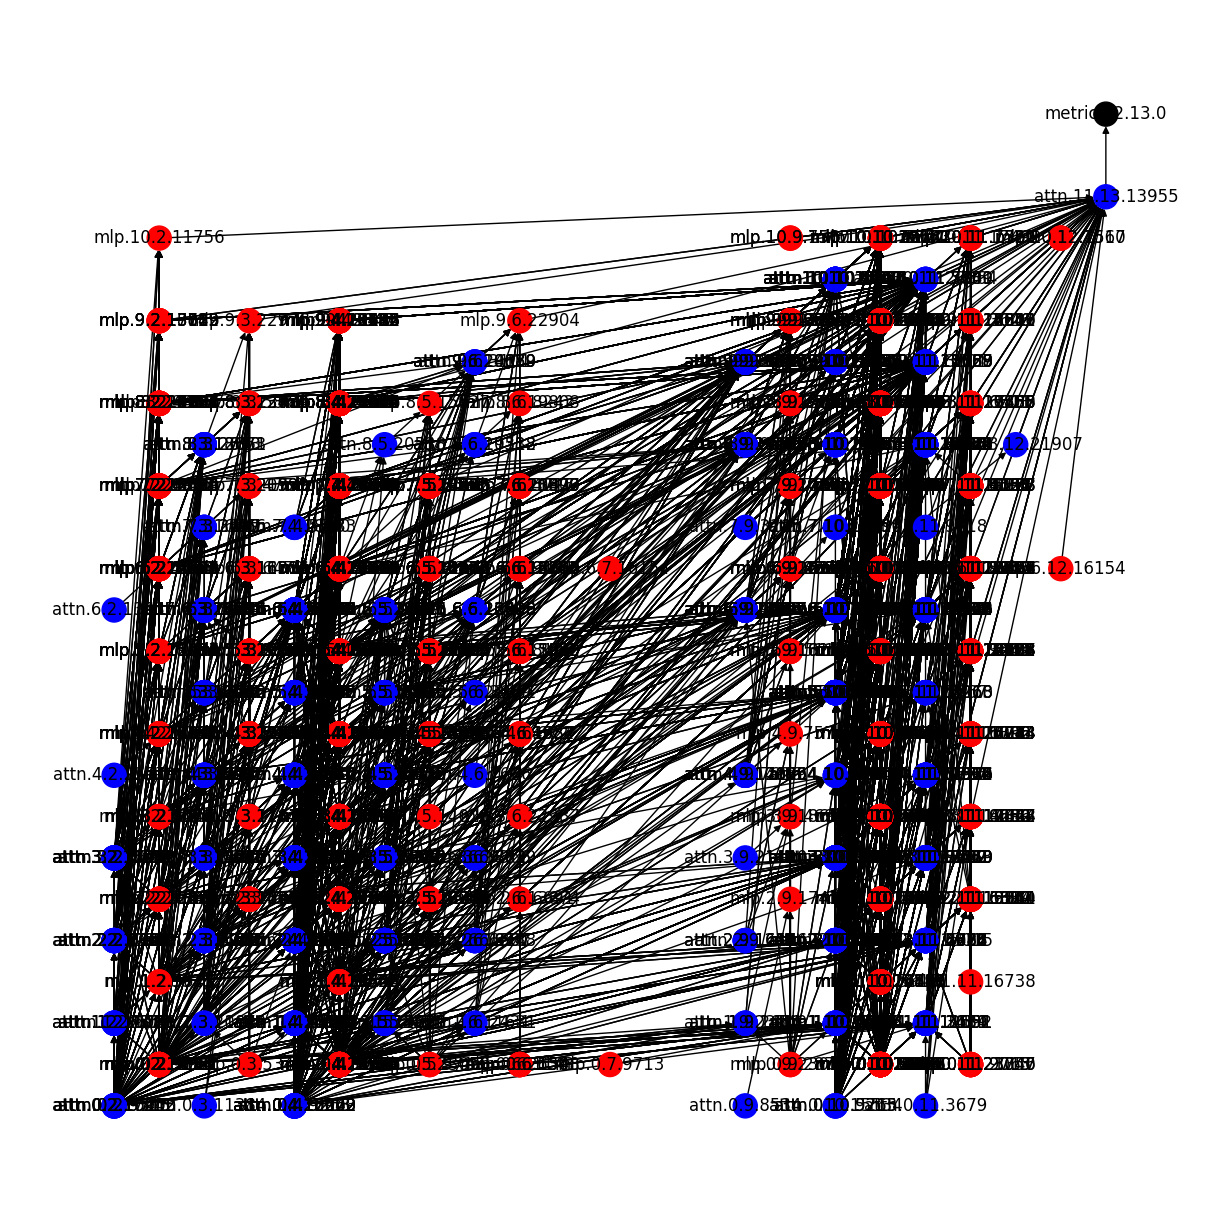

In [28]:
def get_node_position(
    node_name: str,
) -> tuple[float, float]:
    module, layer, token, feature = parse_node_name(node_name)
    x, y = token, layer
    if module == "mlp":
        x += 0.5
        y += 0.5
    return (x, y)


def get_node_color(
    node_name: str,
) -> str:
    module, layer, token, feature = parse_node_name(node_name)
    if module == "mlp":
        return "red"
    elif module == "attn":
        return "blue"
    else:
        return "black"


pos = {node: get_node_position(node) for node in G.nodes}
color = [get_node_color(node) for node in G.nodes]

plt.figure(3, figsize=(12, 12))
nx.draw(G, pos, with_labels=True, node_color=color)
plt.show()